## Code để train và test mô hình

In [ ]:
import os

import tensorflow as tf
from tensorflow import keras 
import numpy as np #
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.utils import plot_model


from sklearn.metrics import confusion_matrix, classification_report


!pip install visualkeras
!pip install tf_explain
import visualkeras
import tf_explain

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!unzip '/content/drive/MyDrive/covpneu.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/pneumonia/Pneumonia-Bacterial (1814).jpg  
  inflating: train/pneumonia/Pneumonia-Bacterial (1816).jpg  
  inflating: train/pneumonia/Pneumonia-Bacterial (1817).jpg  
  inflating: train/pneumonia/Pneumonia-Bacterial (1818).jpg  
  inflating: train/pneumonia/Pneumonia-Bacterial (182).jpg  
  inflating: train/pneumonia/Pneumonia-Bacterial (1820).jpg  
  inflating: train/pneumonia/Pneumonia-Bacterial (1822).jpg  
  inflating: train/pneumonia/Pneumonia-Bacterial (1823).jpg  
  inflating: train/pneumonia/Pneumonia-Bacterial (1826).jpg  
  inflating: train/pneumonia/Pneumonia-Bacterial (1827).jpg  
  inflating: train/pneumonia/Pneumonia-Bacterial (1828).jpg  
  inflating: train/pneumonia/Pneumonia-Bacterial (1829).jpg  
  inflating: train/pneumonia/Pneumonia-Bacterial (1831).jpg  
  inflating: train/pneumonia/Pneumonia-Bacterial (1832).jpg  
  inflating: train/pneumonia/Pneumonia-Bacterial (1833).jpg  
  inflating: train/p

In [ ]:
autotune = tf.data.experimental.AUTOTUNE

batch_size = 32 
num_epochs = 12
seed = 1984

val_split = 0.2
img_size = [224, 224]


class_names = ['covid', 'normal', 'pneumonia']
#make sure to change the loss functions and the num_classes

num_classes = len(class_names)


data_dir = '/content/'


train_val_dir = data_dir + 'train/'
test_dir = data_dir + 'test/'


In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_val_dir,
    validation_split=val_split,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size = batch_size
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_val_dir,
    validation_split=val_split,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size = batch_size
)

In [ ]:
train_data.class_names = class_names
val_data.class_names = class_names

In [ ]:
def one_hot_encoding(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

train_data = train_data.map(one_hot_encoding, num_parallel_calls=autotune)
val_data = val_data.map(one_hot_encoding, num_parallel_calls=autotune)

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
val_data = val_data.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
train_data = train_data.cache().prefetch(buffer_size=autotune)
val_data = val_data.cache().prefetch(buffer_size=autotune)

In [ ]:
model = Sequential()


model.add(Input(shape=(224,224,3)))


model.add(Conv2D(16,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(256,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(512,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())


model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())


model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())


model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())


model.add(Dense(num_classes,activation='softmax'))



model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 32)     128       
 hNormalization)                                                 
                                                        

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("covpneu.h5",
                                                    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(   monitor = "val_loss", #val_auc
                                                     patience=5,
                                                     restore_best_weights=True)

In [ ]:
#learn what the arguments in sgd mean
metrics = ['accuracy',
           tf.keras.metrics.AUC()
          ]
    
model.compile(
        optimizer = tf.keras.optimizers.SGD( 
        learning_rate=0.01, #explain this
        momentum=0.9,  #and this
        nesterov=True,  #all of these
        name="SGD"),
        #loss=tf.losses.BinaryCrossentropy(),
        loss=tf.losses.CategoricalCrossentropy(), #especially this
        metrics=metrics
)

In [ ]:
 history = model.fit(
    train_data,
    validation_data=val_data,
    callbacks=[checkpoint, early_stopping],
    epochs=num_epochs
)

Epoch 1/12
334/334 [==============================] - 49s 96ms/step - loss: 0.2873 - accuracy: 0.8946 - auc: 0.9766 - val_loss: 0.6651 - val_accuracy: 0.7538 - val_auc: 0.9178
Epoch 2/12
334/334 [==============================] - 16s 46ms/step - loss: 0.1471 - accuracy: 0.9468 - auc: 0.9930 - val_loss: 0.6367 - val_accuracy: 0.7958 - val_auc: 0.9295
Epoch 3/12
334/334 [==============================] - 16s 47ms/step - loss: 0.1046 - accuracy: 0.9642 - auc: 0.9958 - val_loss: 0.1233 - val_accuracy: 0.9584 - val_auc: 0.9949
Epoch 4/12
334/334 [==============================] - 16s 48ms/step - loss: 0.0768 - accuracy: 0.9754 - auc: 0.9976 - val_loss: 0.0719 - val_accuracy: 0.9768 - val_auc: 0.9979
Epoch 5/12
334/334 [==============================] - 15s 46ms/step - loss: 0.0551 - accuracy: 0.9812 - auc: 0.9986 - val_loss: 0.0938 - val_accuracy: 0.9712 - val_auc: 0.9951
Epoch 6/12
334/334 [==============================] - 15s 46ms/step - loss: 0.0434 - accuracy: 0.9850 - auc: 0.9992 - va

In [ ]:

#change later
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
)


test_data = test_data.map(one_hot_encoding, num_parallel_calls=autotune)
test_data = test_data.map(lambda x, y: (normalization_layer(x), y))
test_data = test_data.cache().prefetch(buffer_size=autotune)


Found 3335 files belonging to 3 classes.


In [ ]:
model.evaluate(test_data)

105/105 [==============================] - 15s 43ms/step - loss: 0.1543 - accuracy: 0.9538 - auc: 0.9911


[0.15429216623306274, 0.9538230895996094, 0.9911113381385803]

In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_data:
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

ROC AUC score: 0.874


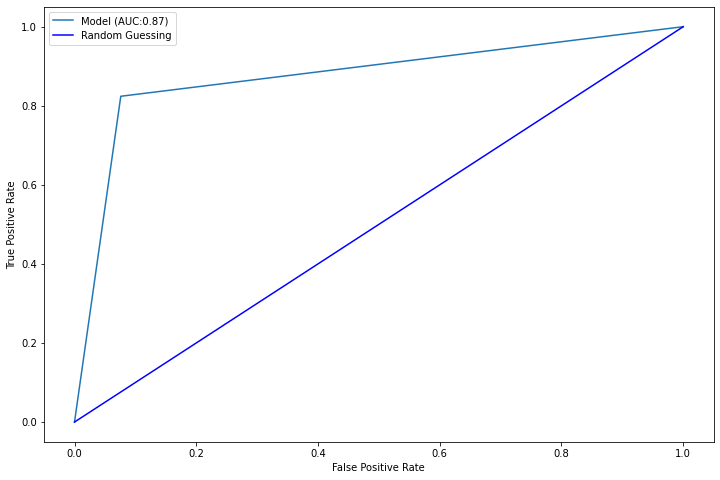

<Figure size 432x288 with 0 Axes>

In [ ]:
#@title Binary ROC

import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score




# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(labels, predictions):
    lb = LabelBinarizer()
    lb.fit(labels)
    labels = lb.transform(labels)
    predictions = lb.transform(predictions)

    
    fpr, tpr, thresholds = roc_curve(labels[:].astype(int), predictions[:])
    #c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ("Model", auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(labels, predictions)


print('ROC AUC score:', multiclass_roc_auc_score(labels, predictions))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()
plt.savefig("AUC_plot.png")

ROC AUC score: 0.9638918645066171


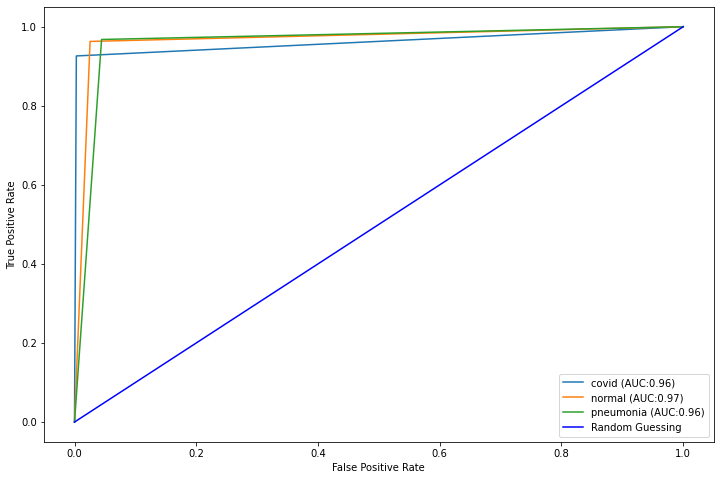

In [ ]:
#@title Multiclass ROC

import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score




# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(labels, predictions, average="macro"):
    lb = LabelBinarizer()
    lb.fit(labels)
    labels = lb.transform(labels)
    predictions = lb.transform(predictions)

    for (idx, c_label) in enumerate(class_names):
        fpr, tpr, thresholds = roc_curve(labels[:,idx].astype(int), predictions[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(labels, predictions, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(labels, predictions))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
#@title Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False, 
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Truth')
    plt.xlabel('Predicted')

# Predict the values from the validation dataset
#Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors
#Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
#Y_true = np.argmax(y_validate,axis = 1)
# compute the confusion matrix

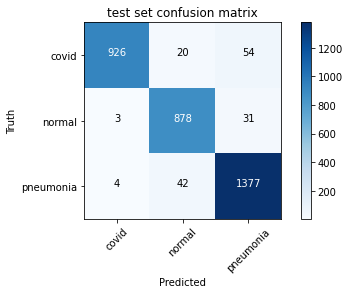

In [ ]:
#@title plot confusion matrix
import itertools
confusion_mtx = confusion_matrix(labels, predictions)
plot_confusion_matrix(confusion_mtx, classes =  class_names, title = 'test set confusion matrix')
plt.savefig("confusion_matrix.png")

In [ ]:
image_path = '/content/final/test/AD/30 (10).jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224, 3))
image

In [ ]:
image = tf.keras.preprocessing.image.img_to_array(image)
image /= 255
image

In [ ]:
data = ([image], None)
image = np.expand_dims(image, axis = 0)
image_pred = model.predict(image)
print(image_pred)
image_pred = np.argmax(image_pred)
print(image_pred)

In [ ]:
model.layers[17].name

In [ ]:
from tf_explain.core.grad_cam import GradCAM

In [ ]:
import matplotlib.image as mpimg

explainer = GradCAM()
grid = explainer.explain(data, model,class_index=image_pred,layer_name='conv2d_5') #it could be the final maxpooling layer though so try out 
explainer.save(grid, ".", "grad_cam.png")

img = mpimg.imread('grad_cam.png')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
model.summary()

In [ ]:
model.layers[15]

In [ ]:
#@title differnet gradcam method
def get_image(path, size):
    img = keras.preprocessing.image.load_img(path, target_size=size)
    # `array` is a float32 NumPy array
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0) / 255
    return array

def make_gradcam_heatmap(img_array, model):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.layers[15] #20
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
    
    # Mark the classifying layers
    classifier_layers = model.layers[-11:] #14

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for classifier_layer in classifier_layers:
        x = classifier_layer(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0], axis=-1)
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    if grads is None:
        raise Exception("No gradient")
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def superimposed_cam(file_path):
    # Prepare image
    img_array = get_image(file_path, img_size)

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(
        img_array, model
    )

    # Rescale the original image
    img = img_array * 255

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img[0])
    
    return superimposed_img, class_names[np.argmax(model.predict(img_array))]

In [ ]:
benign_filenames = tf.io.gfile.glob('/content/melanoma_cancer_dataset/test/benign/*')
malignant_filenames = tf.io.gfile.glob('/content/melanoma_cancer_dataset/test/malignant/*')

In [ ]:
#@title plot
plt.figure(figsize=(20,20))
for n in range(10):
    ax = plt.subplot(5,5,n+1)
    img, pred = superimposed_cam(benign_filenames[n])
    plt.imshow(img)
    plt.title(pred)
    plt.axis("off")
for n in range(15, 25):
    ax = plt.subplot(5,5,n+1)
    img, pred = superimposed_cam(malignant_filenames[n])
    plt.imshow(img)
    plt.title(pred)
    plt.axis("off")

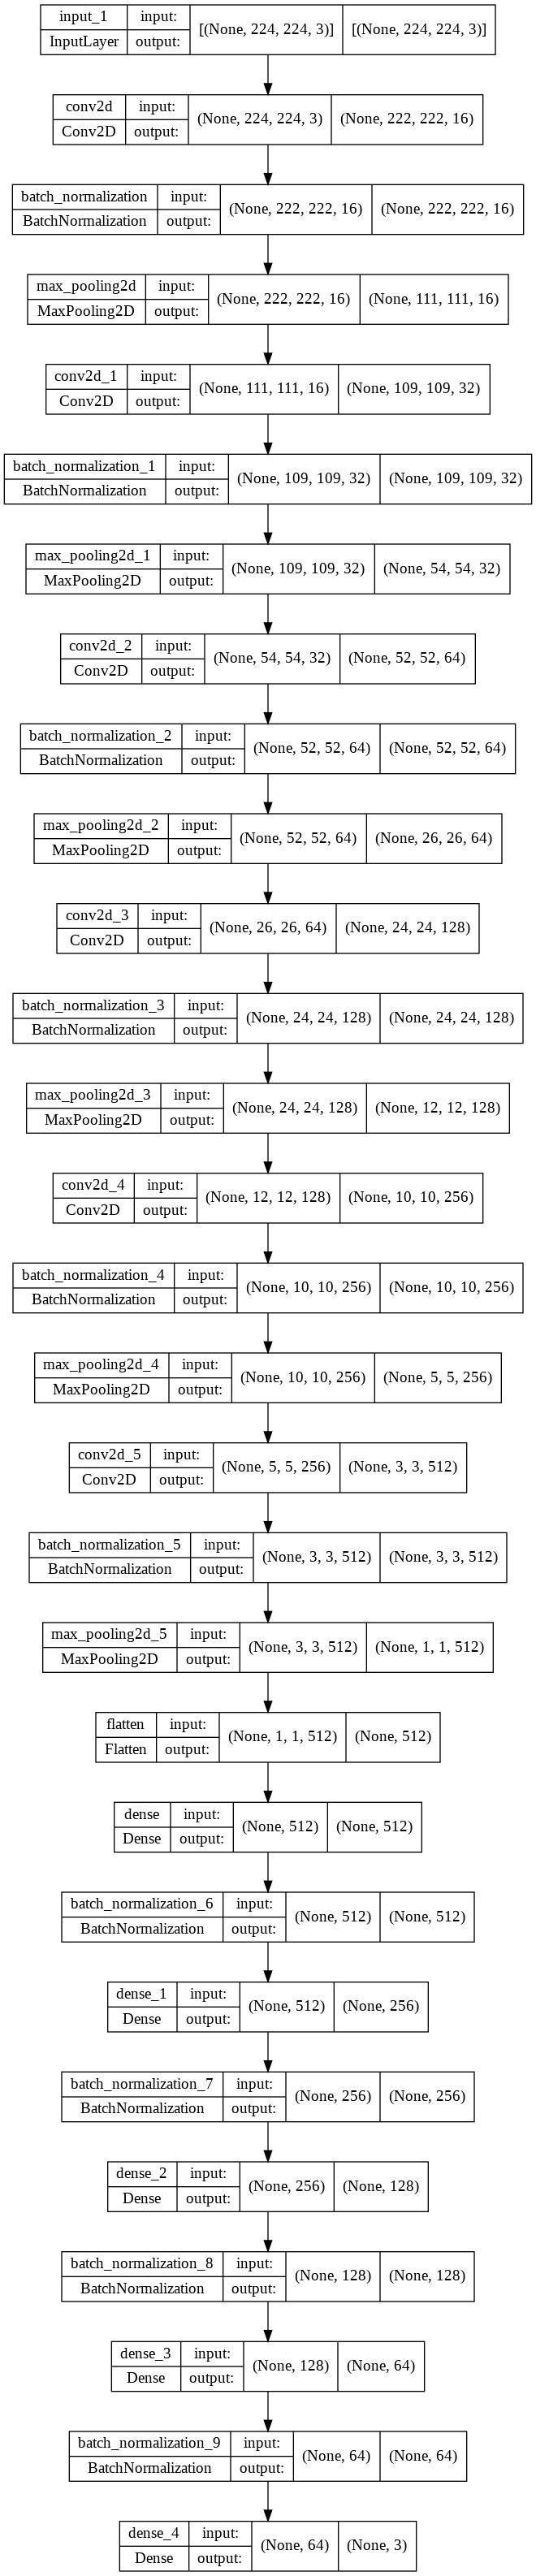

In [ ]:
plot_model(model, to_file='./' + "model_plot.png", show_shapes=True, show_layer_names=True)

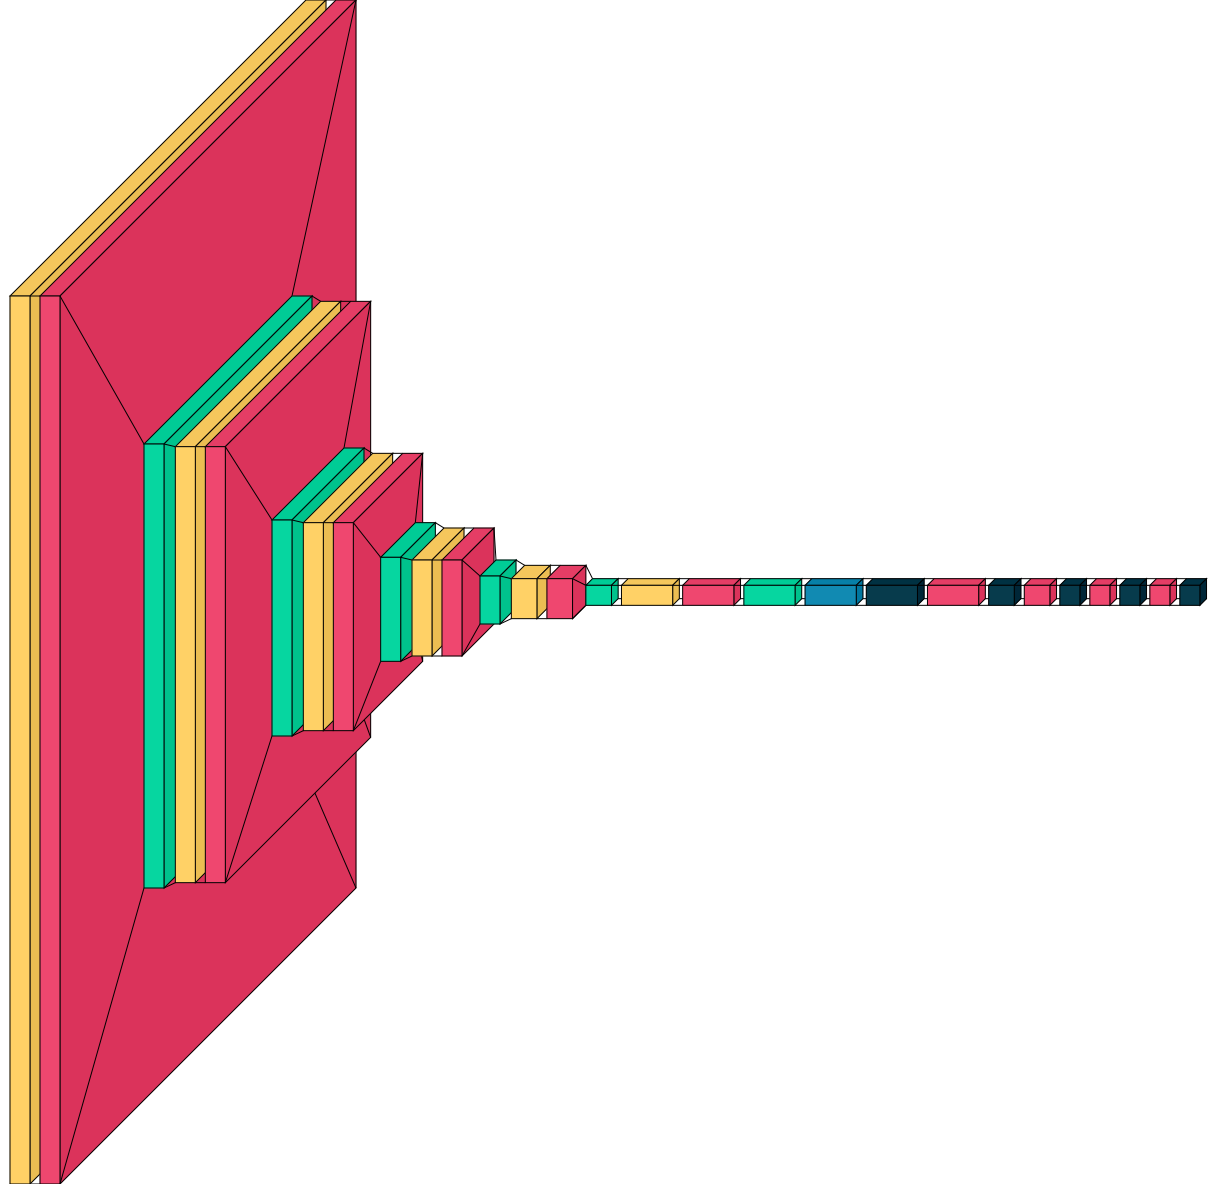

In [ ]:
visualkeras.layered_view(model, to_file='./' + 'output.png')

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("train_vs_val_loss.png")
plt.show()

accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
plt.plot(accuracy_train, 'g', label='Training accuracy')
plt.plot(accuracy_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("train_vs_val_acc.png")
plt.show()

auc_train = history.history['auc_1']
auc_val = history.history['val_auc_1']
plt.plot(auc_train, 'g', label='Training AUC')
plt.plot(auc_val, 'b', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.savefig("train_vs_val_auc.png")
plt.show()

NameError: ignored

In [ ]:
num_img = []
percentage_img = []

total = 0

for i in class_names:
    path = train_val_dir + i
    class_num = len([img for img in os.listdir(path)])
    num_img.append(class_num)
    total += class_num
    
for i in num_img:
    percentage_img.append(f"{i/total:.0%}" )

print("Number of training samples: " + str(total))
print(class_names)
print(num_img)
percentage_img

Number of training samples: 13345
['covid', 'normal', 'pneumonia']
[4000, 3650, 5695]


['30%', '27%', '43%']

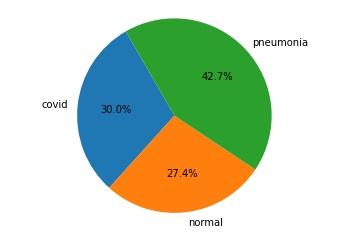

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
fig1, ax1 = plt.subplots()
ax1.pie(num_img,  labels=class_names, autopct='%1.1f%%',
        shadow=False, startangle=120)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig("data_distribution")

plt.show()

AttributeError: ignored

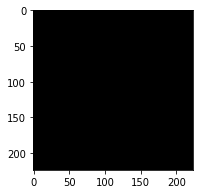

In [ ]:
sample_path = '/content/train/pneumonia'
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_data.class_names[labels[i]])
    plt.axis("off")
    
plt.savefig("sample.png")